In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Đọc toàn bộ dữ liệu

In [2]:
dataset = pd.read_pickle('data/train/cars.pkl')
print(dataset.shape)
dataset.head()

(25582, 15)


,Tên hãng xe,Năm sản xuất,Tỉnh,Số Km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Màu ngoại thất,Màu nội thất,Số chỗ ngồi,Số cửa,Dẫn động,Loại động cơ,Dung tích,Giá
0,audi,2020,TP HCM,30.0,Nhập khẩu,Sedan,Số tự động,Đen,Đen,5,4,AWD,Xăng,3.0,2950.0
1,audi,2014,Hà Nội,94.0,Nhập khẩu,Sedan,Số tự động,Xanh,Nâu,5,4,FWD,Xăng,2.0,560.0
2,audi,2016,TP HCM,50.0,Nhập khẩu,Sedan,Số tự động,Đen,Đen,5,4,FWD,Xăng,2.0,690.0
3,audi,2016,Hà Nội,76.0,Nhập khẩu,Crossover,Số tự động,Xanh,Đen,5,5,AWD,Xăng,2.0,699.0
4,audi,2016,Hà Nội,90.0,Nhập khẩu,SUV,Số tự động,Trắng,Kem,5,5,AWD,Xăng,2.0,739.0


In [3]:
dataset["Năm sản xuất"] = 2024 - dataset["Năm sản xuất"]

In [4]:
categorical_cols = [
    "Tên hãng xe", "Tỉnh", "Xuất xứ", "Kiểu dáng", "Hộp số",
    "Màu ngoại thất","Màu nội thất", "Dẫn động", "Loại động cơ",
]
dataset_encoded = pd.get_dummies(dataset, columns=categorical_cols)
dataset_encoded

,Năm sản xuất,Số Km đã đi,Số chỗ ngồi,Số cửa,Dung tích,Giá,Tên hãng xe_Mercedes Benz,Tên hãng xe_audi,Tên hãng xe_bentley,Tên hãng xe_bmw,...,Màu nội thất_Đỏ,Màu nội thất_Đồng,Dẫn động_4WD,Dẫn động_AWD,Dẫn động_FWD,Dẫn động_RFD,Loại động cơ_Dầu,Loại động cơ_Hybrid,Loại động cơ_Xăng,Loại động cơ_Điện
0,4,30.0,5,4,3.0,2950.0,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
1,10,94.0,5,4,2.0,560.0,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False
2,8,50.0,5,4,2.0,690.0,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False
3,8,76.0,5,5,2.0,699.0,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
4,8,90.0,5,5,2.0,739.0,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26401,2,10.0,5,4,2.0,1838.0,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
26402,2,13.0,5,4,2.0,1979.0,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
26403,2,3.0,7,5,2.0,4189.0,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
26404,3,50.0,5,4,2.0,1739.0,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [5]:
boolean_cols = dataset_encoded.select_dtypes(include=[bool]).columns
dataset_encoded[boolean_cols] = dataset_encoded[boolean_cols].astype(int)
dataset_encoded

,Năm sản xuất,Số Km đã đi,Số chỗ ngồi,Số cửa,Dung tích,Giá,Tên hãng xe_Mercedes Benz,Tên hãng xe_audi,Tên hãng xe_bentley,Tên hãng xe_bmw,...,Màu nội thất_Đỏ,Màu nội thất_Đồng,Dẫn động_4WD,Dẫn động_AWD,Dẫn động_FWD,Dẫn động_RFD,Loại động cơ_Dầu,Loại động cơ_Hybrid,Loại động cơ_Xăng,Loại động cơ_Điện
0,4,30.0,5,4,3.0,2950.0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,10,94.0,5,4,2.0,560.0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,8,50.0,5,4,2.0,690.0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,8,76.0,5,5,2.0,699.0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,8,90.0,5,5,2.0,739.0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26401,2,10.0,5,4,2.0,1838.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
26402,2,13.0,5,4,2.0,1979.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
26403,2,3.0,7,5,2.0,4189.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
26404,3,50.0,5,4,2.0,1739.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


### Chia tập dữ liệu huấn luyện và kiểm thử

In [6]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset_encoded, test_size=0.2, random_state=9)
X_train = train_dataset.drop(columns=['Giá']).values
y_train = train_dataset['Giá'].values
X_test = test_dataset.drop(columns=["Giá"]).values
y_test = test_dataset["Giá"].values

### Xây dựng baseline bằng mô hình Linear Regression

Hàm đánh giá kết quả dự đoán và thực tế

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

def evaluate(y_pred, y_test):
    np.set_printoptions(precision=0)
    values = np.concatenate((y_pred.reshape(-1, 1), y_test.reshape(-1, 1)), 1)
    print(values)
    # Evaluate here
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Percentage Error: {mape}")
    return mse, r2, mae, mape

### Fit mô hình Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test)

[[ 702.  560.]
 [1211.  399.]
 [2066.  739.]
 ...
 [-128.  312.]
 [1117.  868.]
 [4317. 1555.]]
Mean Squared Error: 889410.090581893
Mean Absolute Error: 519.8226590666503
R^2 Score: 0.6569871244501918
Mean Absolute Percentage Error: 0.8156135291582822


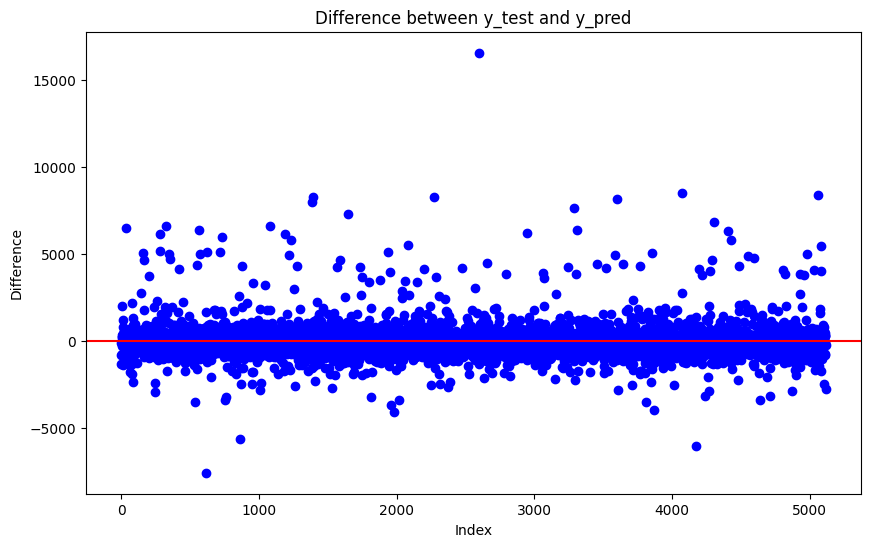

In [9]:
diff = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(diff)), diff, color="blue")
plt.axhline(0, color="red")
plt.title("Difference between y_test and y_pred")
plt.xlabel("Index")
plt.ylabel("Difference")
plt.show()

### Support Vector Regression

In [10]:
from sklearn.svm import SVR

regressor = SVR()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test)

[[ 699.  560.]
 [ 699.  399.]
 [ 699.  739.]
 ...
 [ 699.  312.]
 [ 699.  868.]
 [ 699. 1555.]]
Mean Squared Error: 2856337.360134149
Mean Absolute Error: 751.6352963171676
R^2 Score: -0.1015846366201647
Mean Absolute Percentage Error: 0.6388298929900758


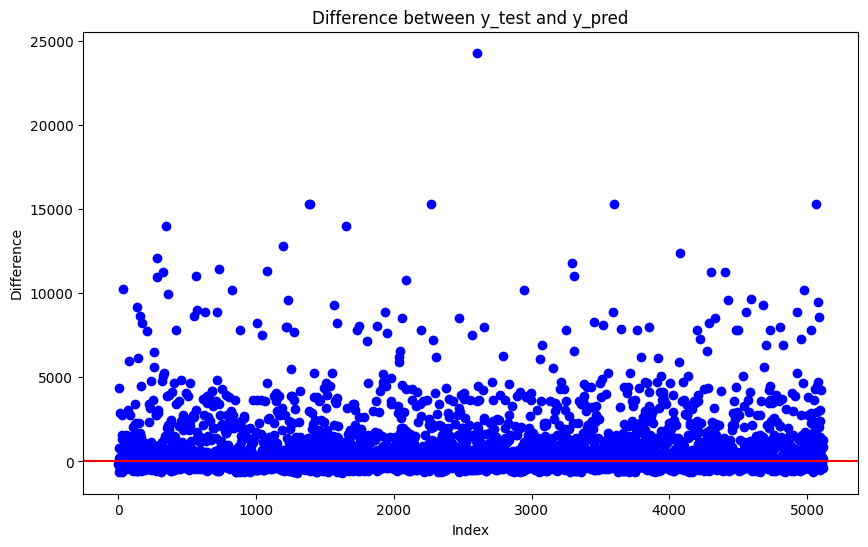

In [14]:
diff = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(diff)), diff, color="blue")
plt.axhline(0, color="red")
plt.title("Difference between y_test and y_pred")
plt.xlabel("Index")
plt.ylabel("Difference")
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV

params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto"],
    "epsilon": [0.1, 0.2, 0.3, 0.4, 0.5],
}

regressor = SVR()

optimizer = GridSearchCV(regressor, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
optimizer.fit(X_train, y_train)
print("Best params", optimizer.best_params_)

KeyboardInterrupt: 